# Benchmarking skopt for comparison to rocketsled optimizers

In [1]:
import numpy as np
# np.random.seed(123)
from time import time

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn
seaborn.set_color_codes()

# plt.rcParams["figure.figsize"] = (10,6)

from skopt.benchmarks import branin, hart6
from skopt import gp_minimize, forest_minimize, dummy_minimize

In [2]:
hartdim = [(0.0, 1.0)] * 6
rosedim = [(-5.0, 10.0)] * 2
branindim = [(-5.0, 10.0), (0.0, 15.0)]

def rose(x):
    """Rosenbrock function - Extensible to N dimensions, but we using 2"""
    x = np.asarray(x)
    r = np.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0, axis=0)
    return r

In [3]:
N = 100
save_csv = True

In [4]:
def skopt_min(optimizer, kwargs, func, dim, iters=100, calls=50, quiet=True):
    runs = np.zeros((N, 50))
    start_time, prev_time = time(), time()
    for i in range(iters):
        res = optimizer(func, dim, n_calls=calls, **kwargs)
        runs[i, :] = res.func_vals
        if not quiet:
            total_time = time() - start_time
            remain_time = (total_time / (i + 1.0)) * (iters - i - 1)
            print(i, "time: ", int(time() - prev_time), "est remain:", int(remain_time), "f", res.fun)
            prev_time = time()
    if not quiet:
        print('total time: ', time() - start_time)
    return runs

def skopt_gp(func, dim, iters=100, calls=50, quiet=True):
    return skopt_min(gp_minimize, {'acq_func': 'EI',
                                   'n_random_starts': 5,
                                   'xi': 0.1,
                                   'noise': 1e-10
                                  },
                     func, dim, iters, calls, quiet)

def skopt_rf(func, dim, iters=100, calls=50, quiet=True):
    return skopt_min(forest_minimize, {'acq_func': 'EI', 
                                       'n_random_starts': 5, 
                                       'base_estimator': 'RF',
                                       'xi': 0.01
                                      },
                     func, dim, iters, calls, quiet)

def skopt_rd(func, dim, iters=100, calls=50, quiet=True):
    return skopt_min(dummy_minimize, {},
                     func, dim, iters, calls, quiet)

In [5]:
def plot_err(data, log=True):
    plt.figure(figsize=(12,6))
    y = np.minimum.accumulate(data, axis=1)
    mean, std = np.mean(y, axis=0), np.std(y, axis=0)
    p25, p75 = np.percentile(y, [12.5, 87.5], axis=0)
    plt.plot(mean, 'o-')
    if log:
        plt.yscale('log')
    plt.plot(p25, '--b', alpha=0.5)
    plt.plot(p75, '--b', alpha=0.5)
    plt.fill_between(np.arange(50), mean-std, mean+std, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_comp(gp_data, rf_data, rd_data, log=True, std=False, quant=False):
    y1 = np.mean(np.minimum.accumulate(gp_data, axis=1), axis=0)
    y2 = np.mean(np.minimum.accumulate(rf_data, axis=1), axis=0)
    y3 = np.mean(np.minimum.accumulate(rd_data, axis=1), axis=0)

    plt.figure(figsize=(12,6))
    plt.plot(y1, 'o-', label="GP")
    plt.plot(y2, 'v-', label="RF")
    plt.plot(y3, '^-', label="RAND")
    if log:
        plt.yscale('log')
    plt.legend()
    plt.tight_layout()

 ## 100 evaluations of rosenbrock

In [6]:
rose_gp = np.zeros((N, 50))

try:
    rose_gp = np.loadtxt("rose-gp-skopt.csv", delimiter=',')
except OSError:
    rose_gp = skopt_gp(rose, rosedim, iters=N, quiet=False)
    if save_csv:
        np.savetxt("rose-gp-skopt.csv", rose_gp, delimiter=',')

0 time:  11 est remain: 1134 f 0.6329530064723374
1 time:  9 est remain: 1013 f 2.768587838929794
2 time:  12 est remain: 1073 f 1.2122043168510035
3 time:  11 est remain: 1075 f 0.3000649552538002
4 time:  11 est remain: 1061 f 0.38630241023438183
5 time:  10 est remain: 1034 f 0.5878048064494642
6 time:  11 est remain: 1023 f 0.1392268871348245
7 time:  12 est remain: 1024 f 0.002331140699971618
8 time:  9 est remain: 994 f 0.6202766468584597
9 time:  11 est remain: 991 f 2.970610894474852
10 time:  9 est remain: 969 f 6.90644880709357
11 time:  11 est remain: 965 f 1.43386085252277
12 time:  11 est remain: 958 f 2.217657277281239
13 time:  9 est remain: 939 f 2.224605631839689
14 time:  13 est remain: 942 f 1.8731874404918183
15 time:  11 est remain: 931 f 6.922426167275785
16 time:  10 est remain: 919 f 3.2644538730425543
17 time:  422 est remain: 2781 f 0.355764318817782
18 time:  15 est remain: 2666 f 0.3881420356680209
19 time:  10 est remain: 2545 f 0.09609349342440839
20 time:

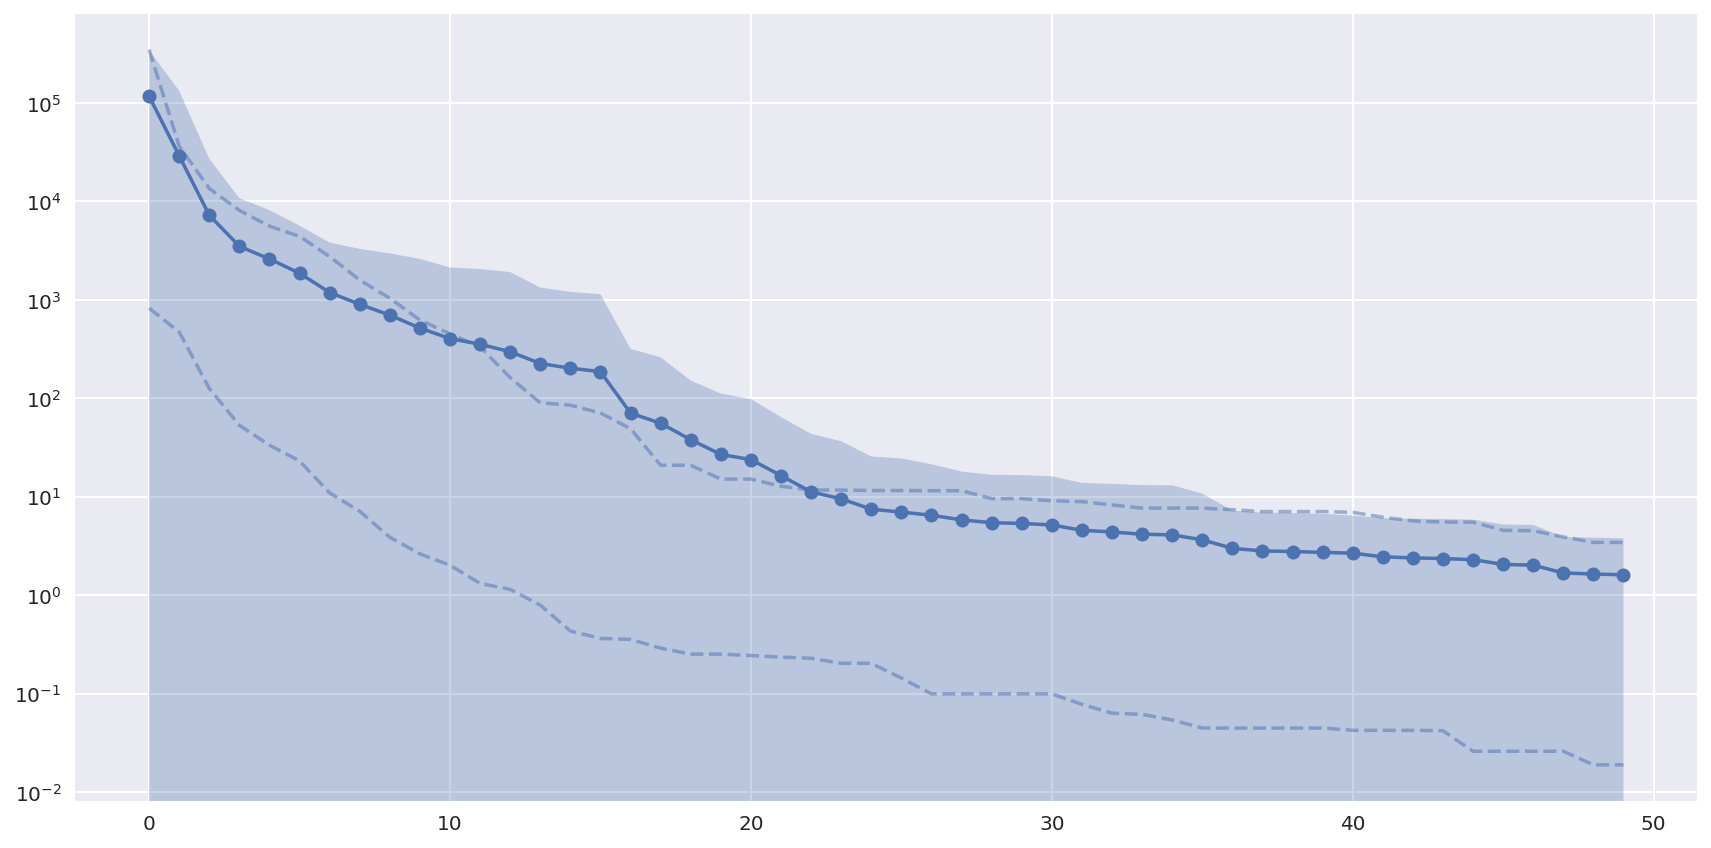

In [7]:
plot_err(rose_gp, log=True)

In [8]:
rose_for = np.zeros((N, 50))

try:
    rose_for = np.loadtxt("rose-for-skopt.csv", delimiter=',')
except OSError:
    rose_for = skopt_rf(rose, rosedim, iters=N, quiet=False)
    if save_csv:
        np.savetxt("rose-for-skopt.csv", rose_for, delimiter=',')

0 time:  9 est remain: 920 f 5.88453991767863
1 time:  9 est remain: 900 f 114.67006492637708
2 time:  9 est remain: 888 f 2.3638008358546045
3 time:  8 est remain: 868 f 2197.776467081544
4 time:  9 est remain: 858 f 1055.3546948676312
5 time:  9 est remain: 853 f 5.475965425950767
6 time:  9 est remain: 843 f 5.959907599889599
7 time:  9 est remain: 836 f 45.47756957800449
8 time:  10 est remain: 842 f 8.963319807818062
9 time:  9 est remain: 831 f 23.773356598028123
10 time:  9 est remain: 820 f 3.4169244467871662
11 time:  9 est remain: 812 f 70.96883820881243
12 time:  9 est remain: 801 f 17.11520158540028
13 time:  9 est remain: 793 f 4.677320850418645
14 time:  9 est remain: 784 f 465.66702954270534
15 time:  9 est remain: 775 f 1.8417582589183348
16 time:  9 est remain: 767 f 33.78194162169955
17 time:  10 est remain: 762 f 28.03314934336711
18 time:  9 est remain: 754 f 3.0765466253130436
19 time:  9 est remain: 743 f 32.644944878938226
20 time:  9 est remain: 734 f 4.78078535

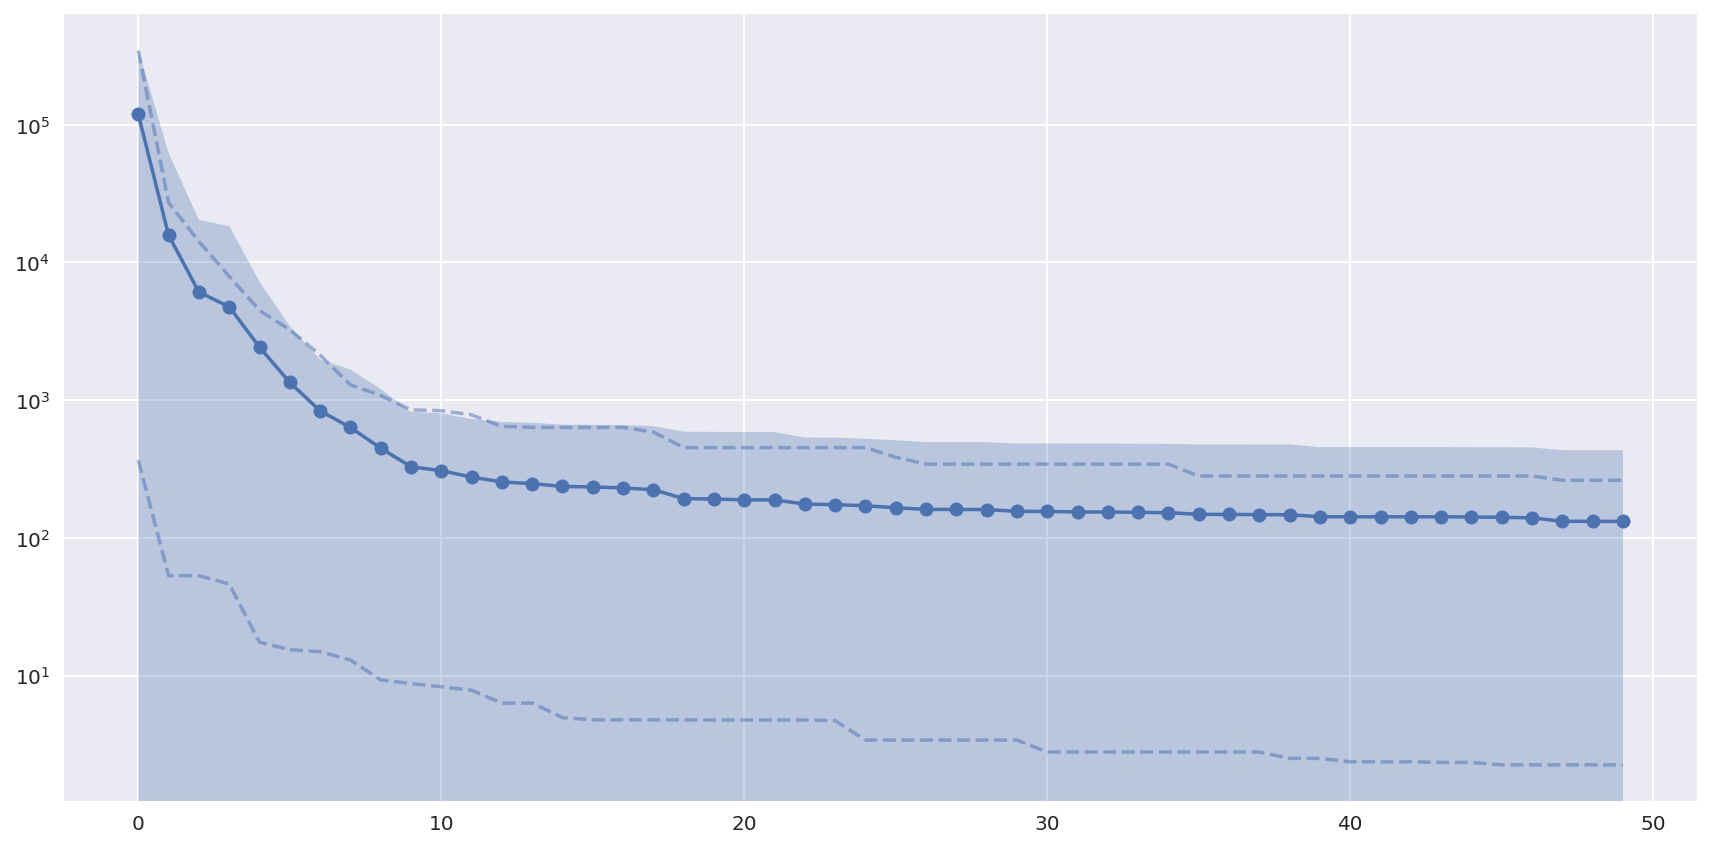

In [9]:
plot_err(rose_for)

In [10]:
rose_dum = np.zeros((N, 50))
rose_dum = skopt_rd(rose, rosedim, iters=N, quiet=True)

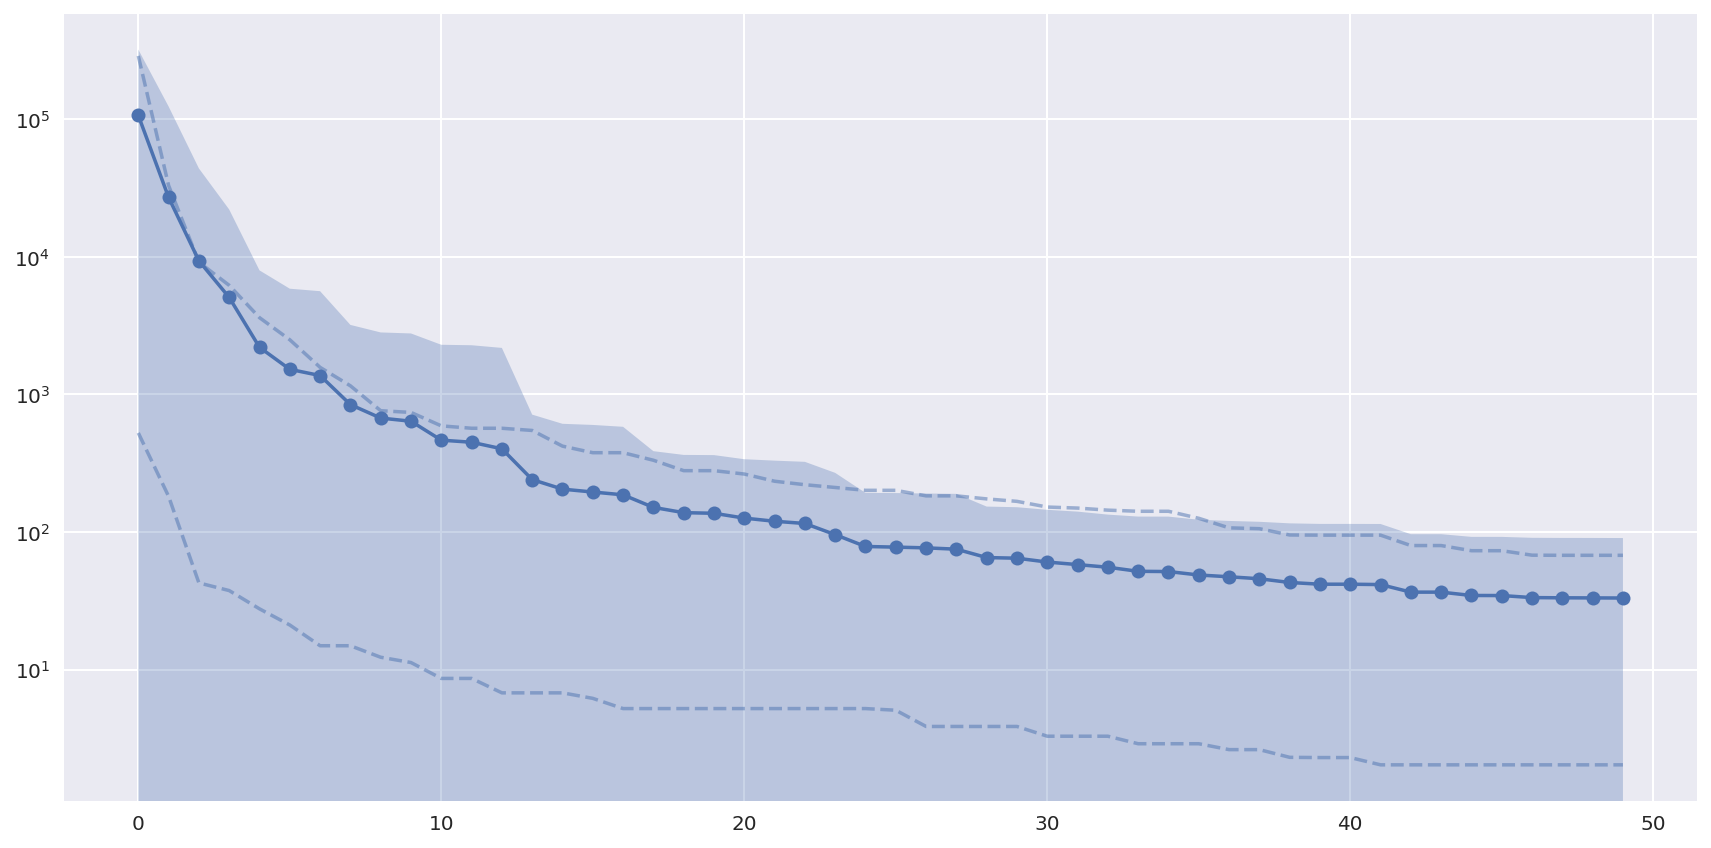

In [11]:
plot_err(rose_dum)

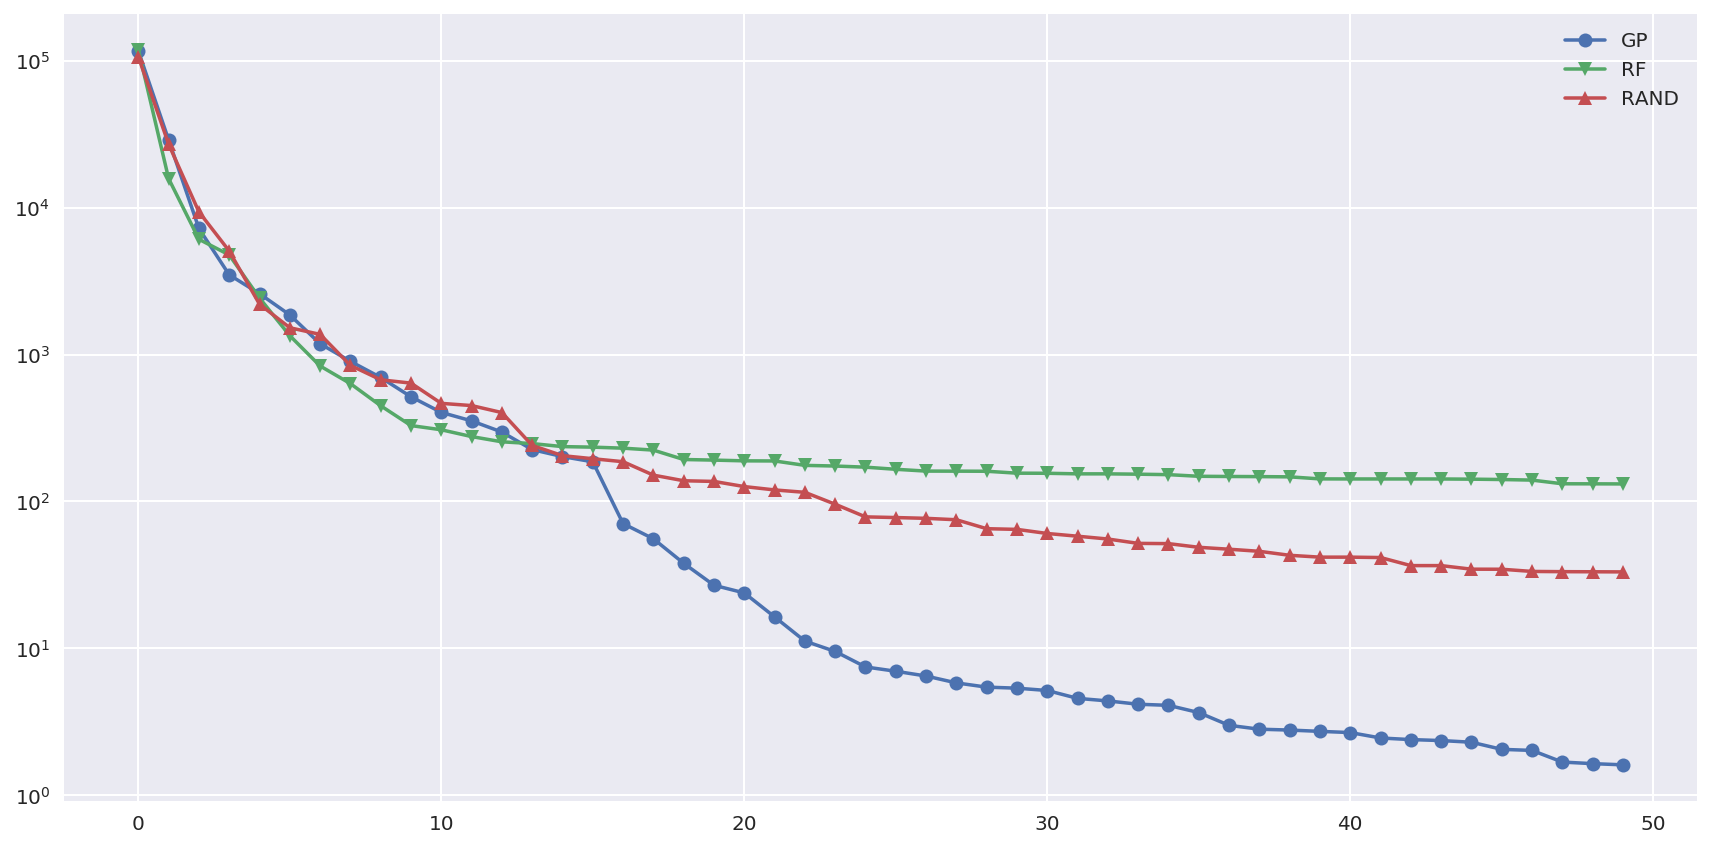

In [12]:
plot_comp(rose_gp, rose_for, rose_dum)

## 100 evaluations of branin

In [13]:
bran_gp = np.zeros((N, 50))

try:
    bran_gp = np.loadtxt("bran-gp-skopt.csv", delimiter=',')
except OSError:
    bran_gp = skopt_gp(branin, branindim, iters=N, quiet=False)
    if save_csv:
        np.savetxt("bran-gp-skopt.csv", bran_gp, delimiter=',')

0 time:  12 est remain: 1192 f 0.4078007984289638
1 time:  18 est remain: 1484 f 0.40908026725357693
2 time:  21 est remain: 1687 f 0.40142935005762403
3 time:  13 est remain: 1587 f 0.4027185658129184
4 time:  12 est remain: 1486 f 0.397892526854438
5 time:  25 est remain: 1618 f 0.4077348522711848
6 time:  13 est remain: 1558 f 0.40927780194542684
7 time:  12 est remain: 1490 f 0.3995641992080028
8 time:  443 est remain: 5791 f 0.40092619559279186
9 time:  13 est remain: 5272 f 0.4026216740369666
10 time:  16 est remain: 4870 f 0.4110496856425474
11 time:  128 est remain: 5353 f 0.40277737563793714
12 time:  446 est remain: 7874 f 0.40576249543122245
13 time:  16 est remain: 7328 f 0.40069007784377675
14 time:  12 est remain: 6830 f 0.4054438038889234
15 time:  14 est remain: 6405 f 0.40014649493029886
16 time:  13 est remain: 6020 f 0.3985934029315832
17 time:  11 est remain: 5668 f 0.39937556658679974
18 time:  11 est remain: 5355 f 0.4009675290903374
19 time:  11 est remain: 5069 

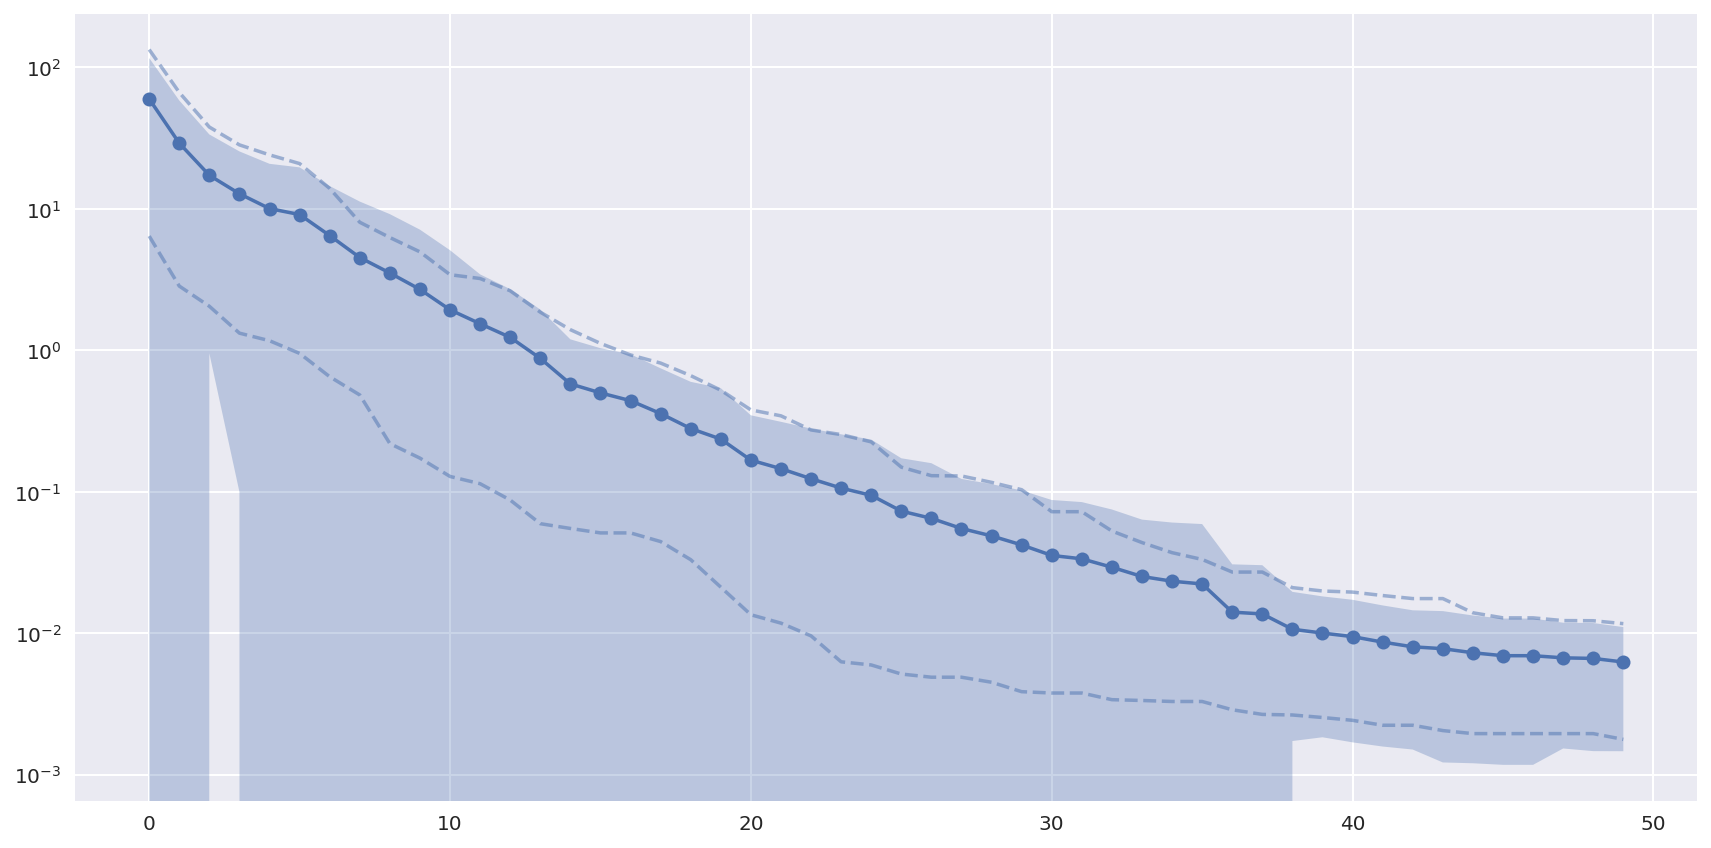

In [14]:
plot_err(bran_gp - 0.397887)

In [15]:
bran_for = np.zeros((N, 50))

try:
    bran_for = np.loadtxt("bran-for-skopt.csv", delimiter=',')
except OSError:
    bran_for = skopt_rf(branin, branindim, iters=N, quiet=False)
    if save_csv:
        np.savetxt("bran-for-skopt.csv", bran_for, delimiter=',')

0 time:  9 est remain: 926 f 10.27201024159841
1 time:  8 est remain: 867 f 0.41638358847369084
2 time:  8 est remain: 848 f 0.9492817921046317
3 time:  9 est remain: 854 f 3.1612142263620484
4 time:  9 est remain: 858 f 1.4759437021098716
5 time:  9 est remain: 860 f 0.8251529972948823
6 time:  9 est remain: 858 f 13.041640770697192
7 time:  9 est remain: 856 f 0.8664923444387558
8 time:  9 est remain: 850 f 3.2580044022995933
9 time:  9 est remain: 845 f 4.824322766111774
10 time:  9 est remain: 839 f 9.861608065384578
11 time:  9 est remain: 829 f 1.2848557138307672
12 time:  9 est remain: 819 f 2.041091786440635
13 time:  9 est remain: 808 f 4.3146635134974005
14 time:  9 est remain: 797 f 0.7333588631879202
15 time:  9 est remain: 787 f 0.5159600027858531
16 time:  9 est remain: 779 f 6.800426925087858
17 time:  8 est remain: 767 f 1.5990204047667618
18 time:  9 est remain: 758 f 1.3046573099544645
19 time:  9 est remain: 748 f 0.7481014607537979
20 time:  9 est remain: 739 f 0.60

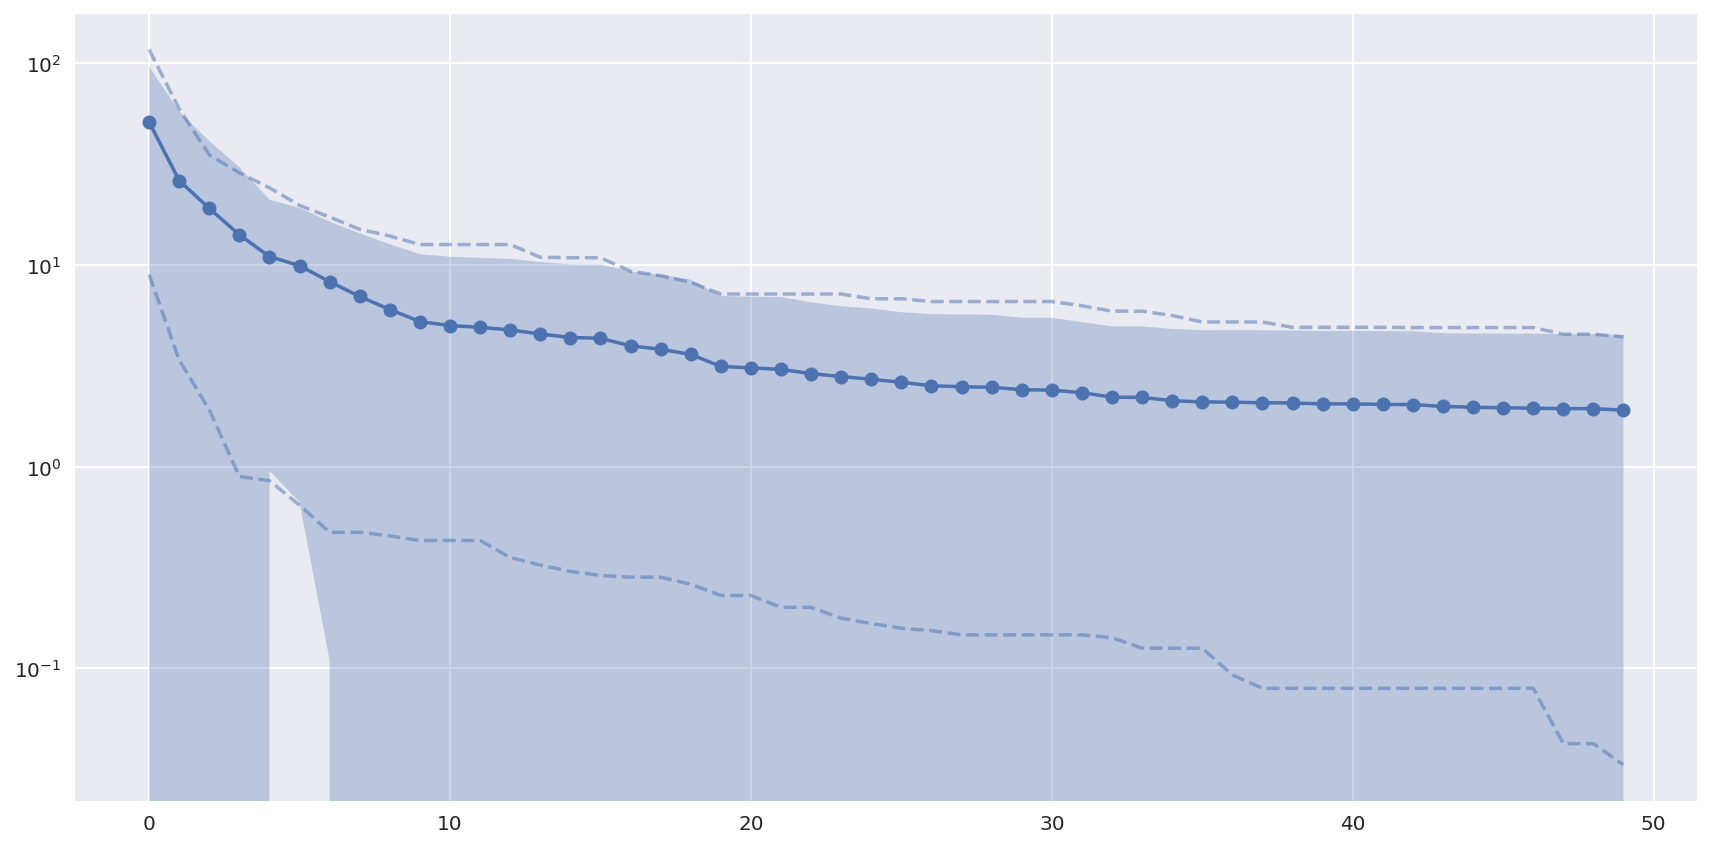

In [16]:
plot_err(bran_for - 0.397887)

In [17]:
bran_dum = np.zeros((N, 50))
bran_dum = skopt_rd(branin, branindim, iters=N, quiet=True)

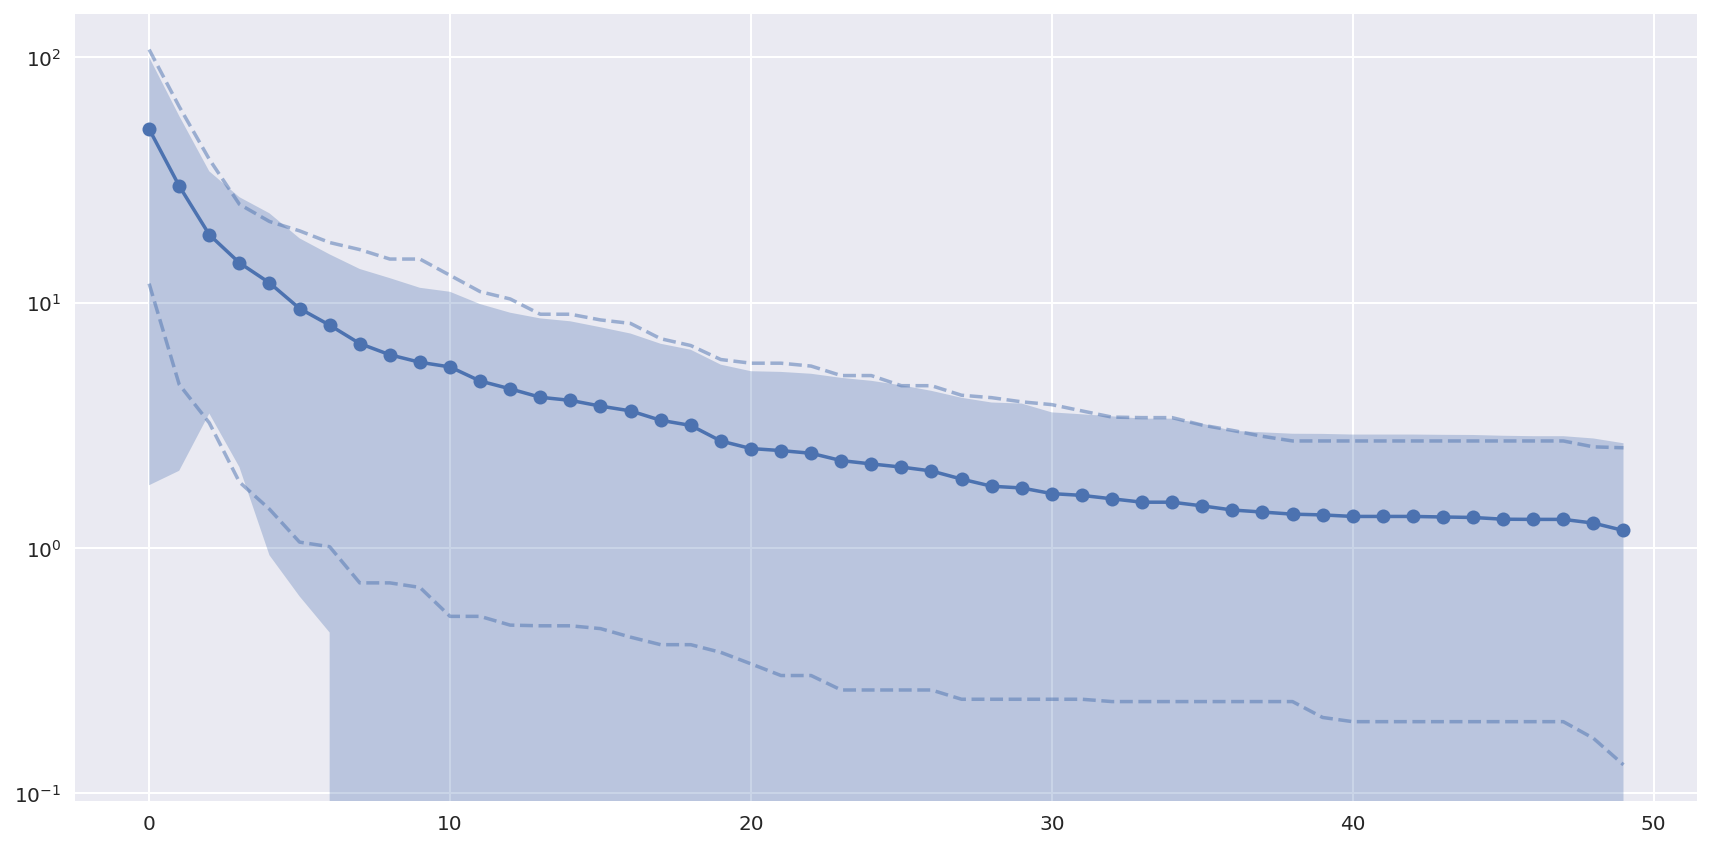

In [18]:
plot_err(bran_dum - 0.397887)

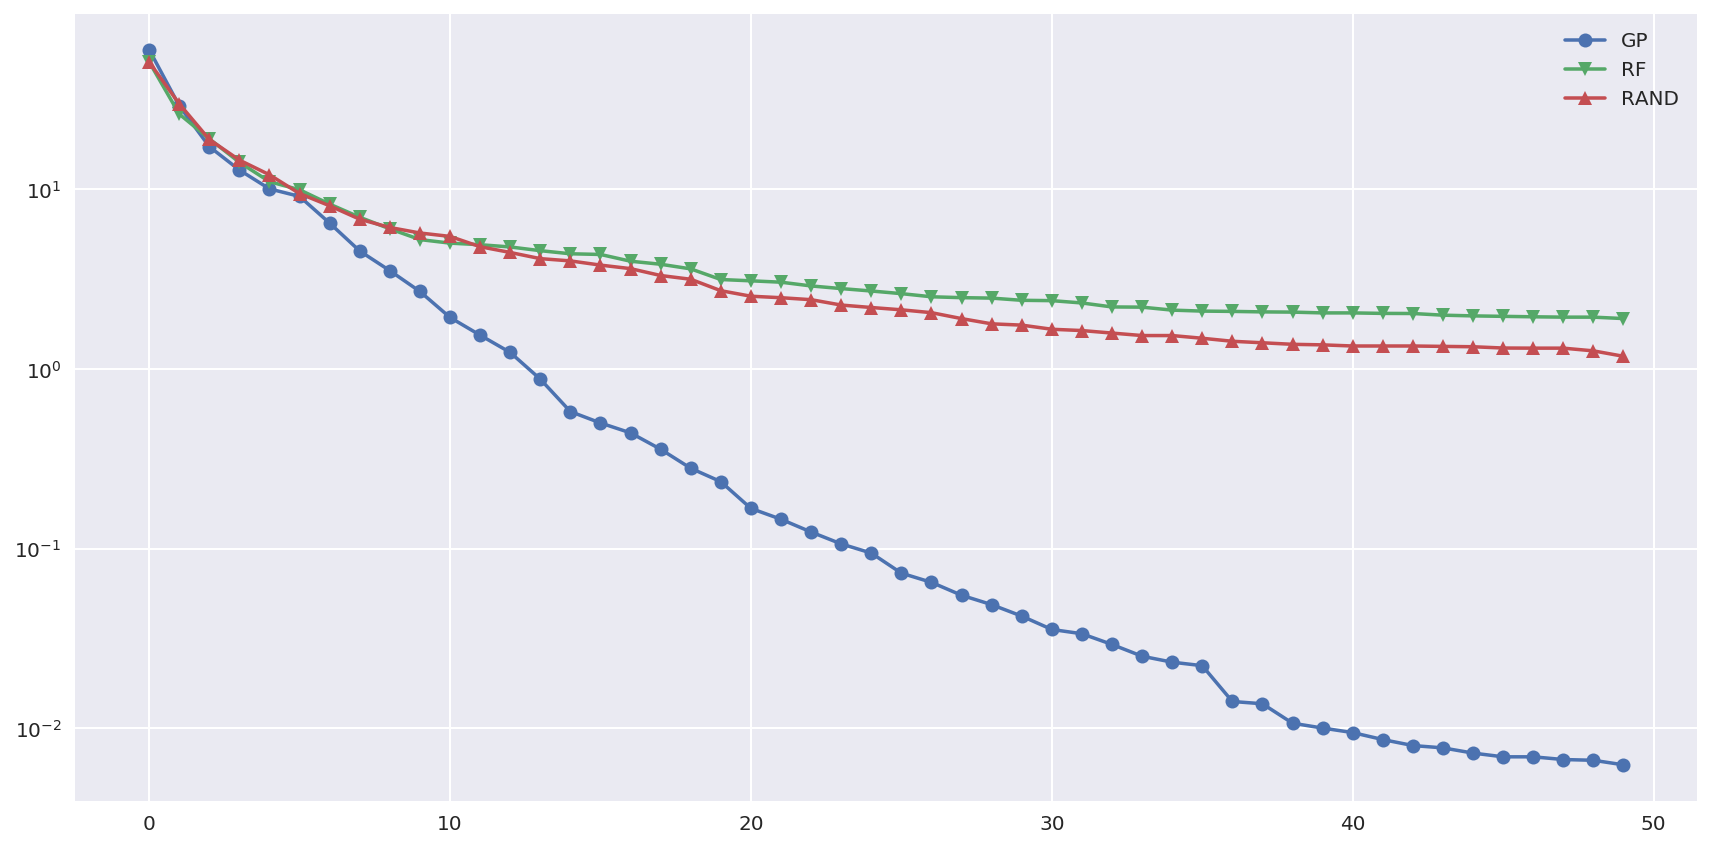

In [19]:
plot_comp(bran_gp - 0.397887, bran_for - 0.397887, bran_dum - 0.397887)

## 100 evaluations of hart6

In [20]:
hart_gp = np.zeros((N, 50))

try:
    hart_gp = np.loadtxt("hart-gp-skopt.csv", delimiter=',')
except OSError:
    hart_gp = skopt_gp(hart6, hartdim, iters=N, quiet=False)
    if save_csv:
        np.savetxt("hart-gp-skopt.csv", hart_gp, delimiter=',')

0 time:  16 est remain: 1630 f -3.148929733190872
1 time:  18 est remain: 1689 f -2.7697487510432044
2 time:  17 est remain: 1664 f -3.120477449073462
3 time:  16 est remain: 1636 f -3.1261845717204797
4 time:  13 est remain: 1557 f -3.11174934339165
5 time:  19 est remain: 1588 f -3.1425446701485025
6 time:  14 est remain: 1545 f -3.058935815632551
7 time:  16 est remain: 1528 f -2.952410055749265
8 time:  19 est remain: 1542 f -3.0623411975937453
9 time:  18 est remain: 1535 f -3.2704290092586636
10 time:  19 est remain: 1538 f -3.3111991101012657
11 time:  17 est remain: 1520 f -3.10281067758188
12 time:  17 est remain: 1503 f -3.287638216229288
13 time:  15 est remain: 1473 f -3.189869037033626
14 time:  16 est remain: 1453 f -2.0460058644013457
15 time:  20 est remain: 1456 f -3.1387498501775926
16 time:  20 est remain: 1452 f -3.2865755549205358
17 time:  17 est remain: 1435 f -3.27986154161145
18 time:  21 est remain: 1435 f -3.2936420464706426
19 time:  20 est remain: 1428 f -3

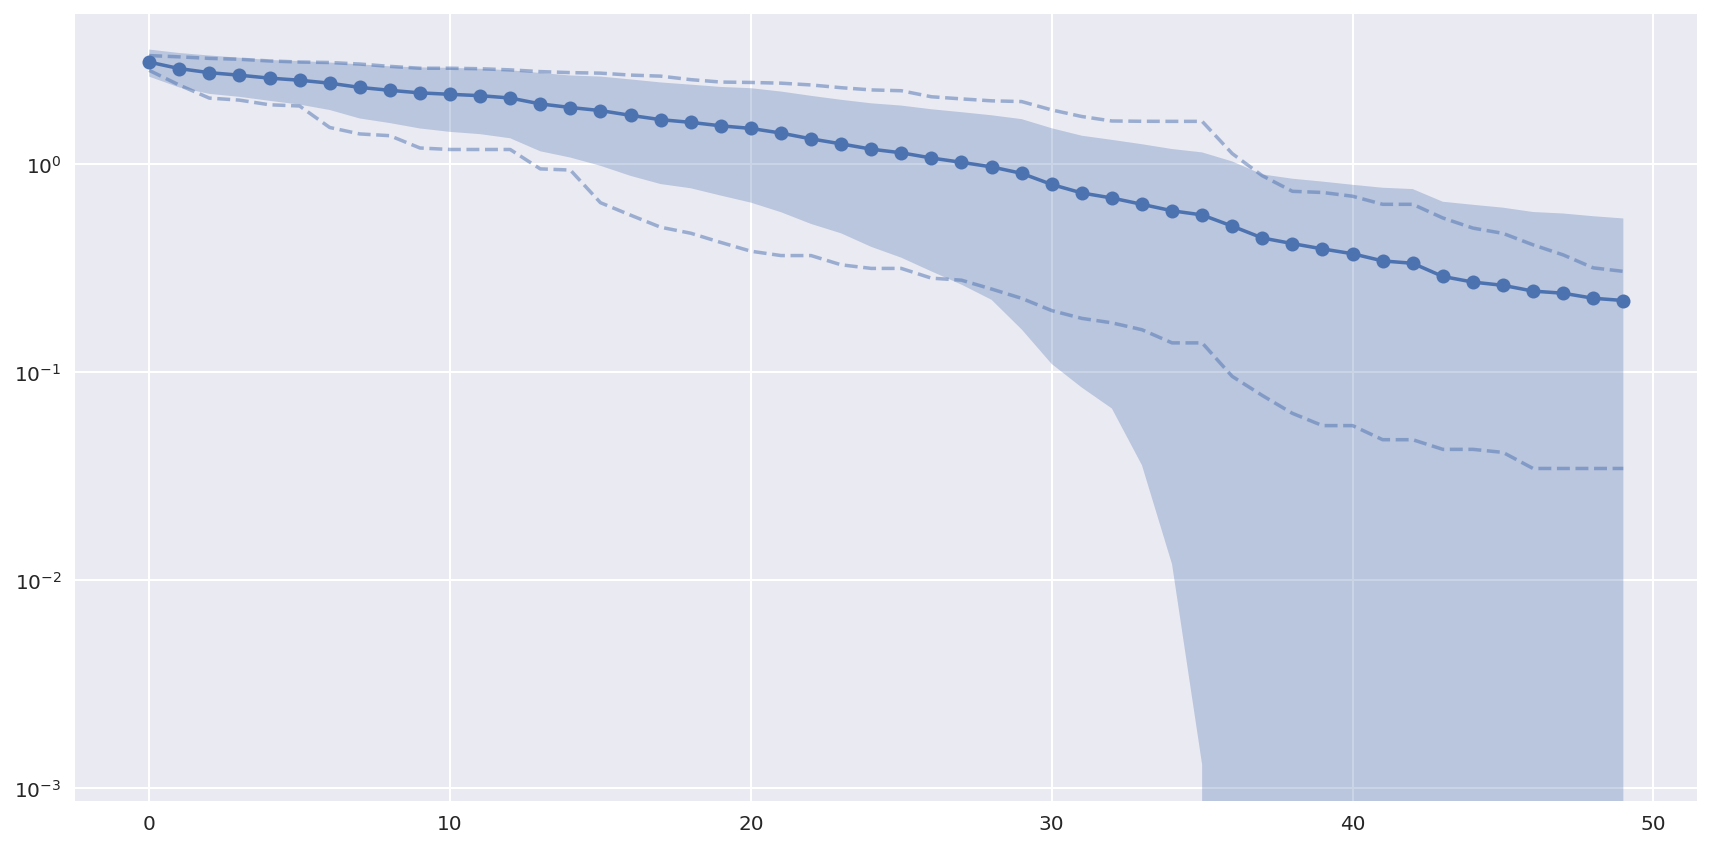

In [21]:
plot_err(hart_gp + 3.32237)

In [22]:
hart_for = np.zeros((N, 50))

try:
    hart_for = np.loadtxt("hart-for-skopt.csv", delimiter=',')
except OSError:
    hart_for = skopt_rf(hart6, hartdim, iters=N, quiet=False)
    if save_csv:
        np.savetxt("hart-for-skopt.csv", hart_for, delimiter=',')

0 time:  10 est remain: 995 f -1.1426809348939162
1 time:  10 est remain: 1011 f -2.53573028760927
2 time:  10 est remain: 1008 f -2.9991145587202475
3 time:  10 est remain: 1000 f -3.1002006824182
4 time:  10 est remain: 991 f -1.5014399762377744
5 time:  10 est remain: 979 f -2.36936552479599
6 time:  10 est remain: 966 f -2.696235453069386
7 time:  10 est remain: 958 f -3.195930308628771
8 time:  10 est remain: 946 f -2.312493020825361
9 time:  10 est remain: 937 f -2.3380955294643893
10 time:  10 est remain: 926 f -1.7437194785728727
11 time:  10 est remain: 915 f -1.9269788832662804
12 time:  10 est remain: 902 f -2.192430606730404
13 time:  10 est remain: 892 f -3.058012531238254
14 time:  10 est remain: 881 f -1.5823766945255884
15 time:  10 est remain: 872 f -2.1417713802382967
16 time:  10 est remain: 861 f -2.2866462057038306
17 time:  10 est remain: 853 f -2.304065813830676
18 time:  10 est remain: 843 f -2.957064282234326
19 time:  10 est remain: 832 f -2.258521510772746
20

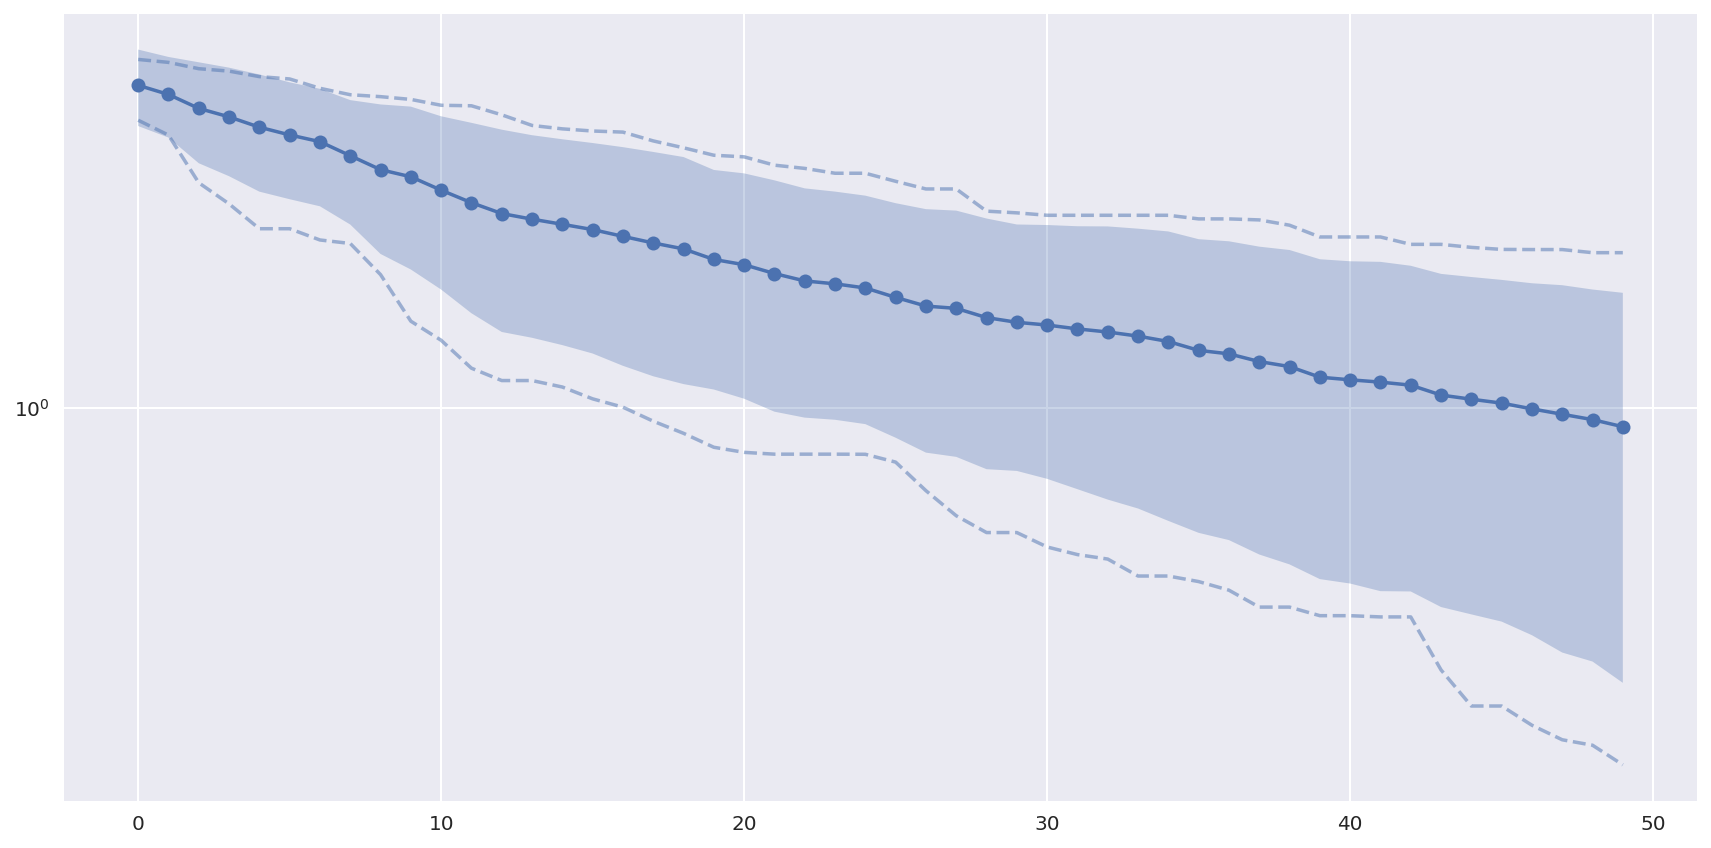

In [23]:
plot_err(hart_for + 3.32237)

In [24]:
start_time, prev_time = time(), time()
iters = 100
hart_dum = np.zeros((iters, 50))
hart_dum = skopt_rd(hart6, hartdim, iters=N, quiet=True)

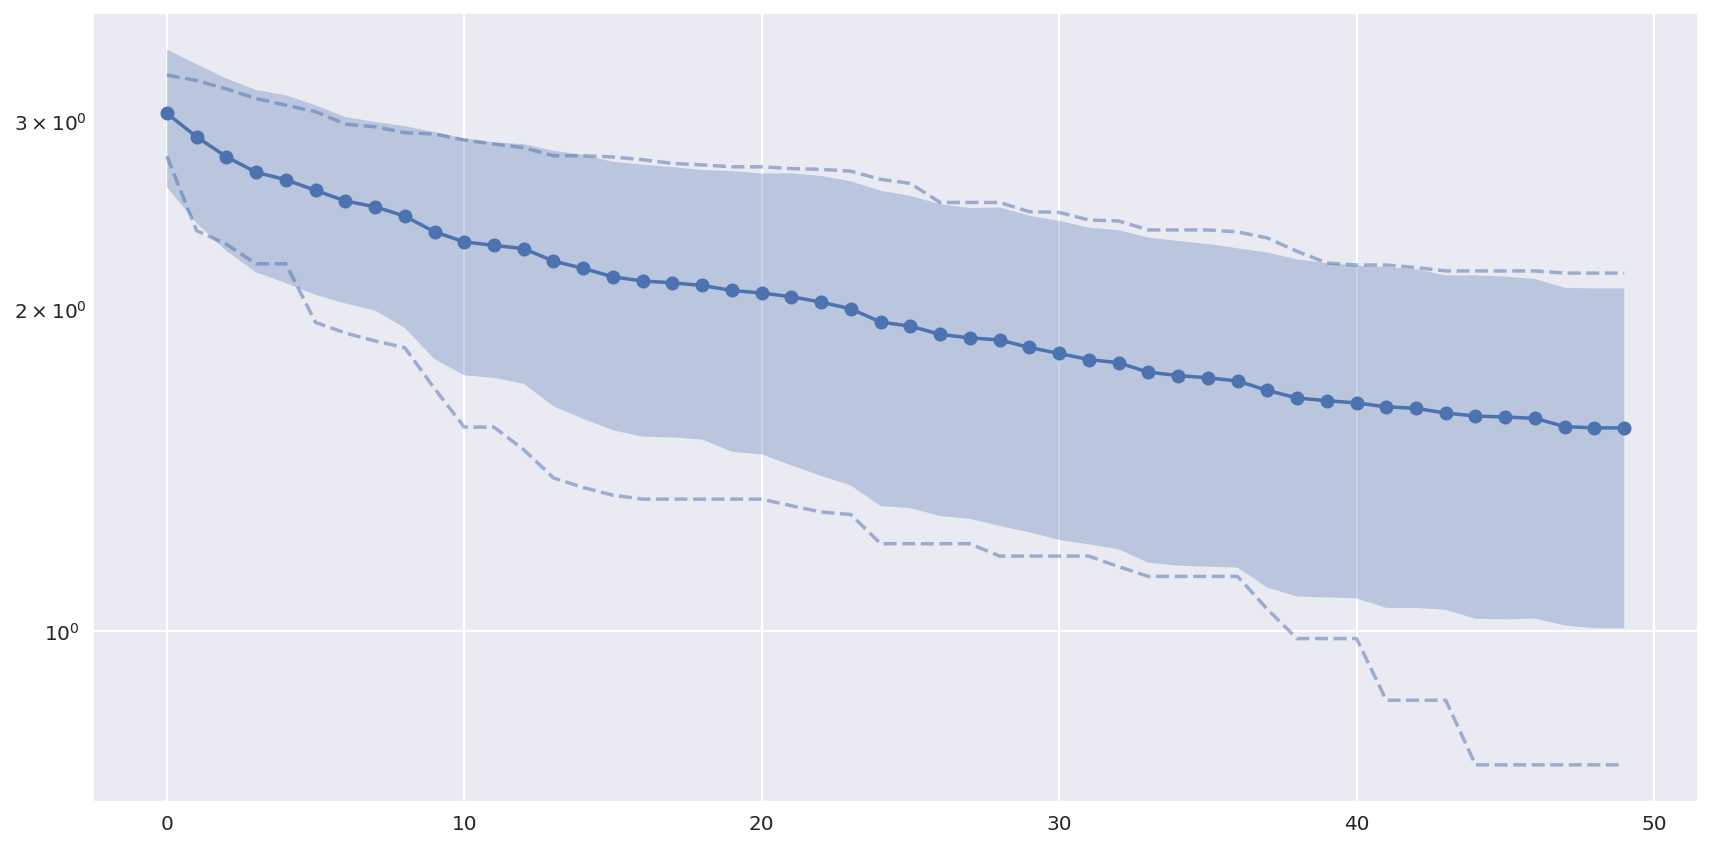

In [25]:
plot_err(hart_dum + 3.32237)

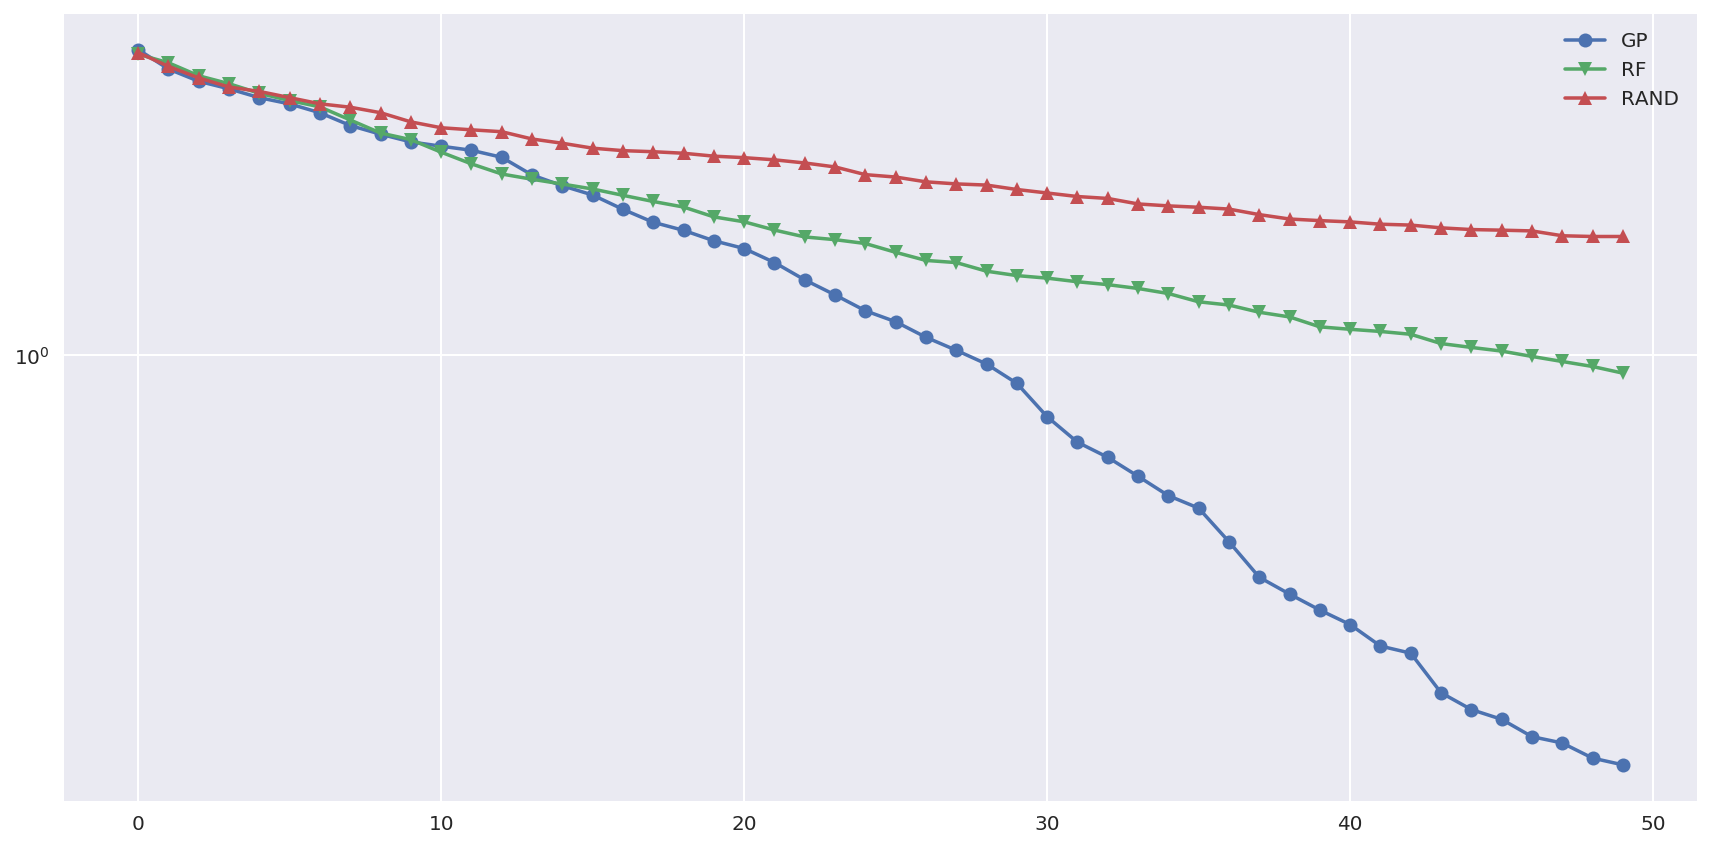

In [26]:
plot_comp(hart_gp + 3.32237, hart_for + 3.32237, hart_dum + 3.32237)